# **ECS 7001 - NN & NNLP**

## **Lab 2: Skip-gram Model for Word2Vec**

<br>

**1st February**

There are two Word2Vec architectures for creating word embeddings: the Continuous Bag of Words (CBOW) architecture and the Skip Gram architecture . In this lab, we will obtain our own word embeddings by training a skip-gram neural network model. Some of the code for this will be supplied here but in some sections, you will be required to implement the code yourself. Hints and
tips will be provided.


The skip gram model is essentially a feedforward neural network with one hidden layer, trained to predict the context word given a target word. There are two ways to train this model: (1) using a hierarchical softmax function and/or (2) by negative sampling. In this lab, we will be training using
negative sampling. To train with negative sampling, the model is cast as a binary classification problem. The dataset would consist of positive and negative examples of the form:

Input | label
--| --
(target_word, word_in_its_context)       |  1 
(target_word, word_not_in_its_context)   |  0

created from the sentences in a corpus. The exact number of positive and negative examples will depend on the window size, and the balance ratio of positive:negative examples.  

As an example, consider the sentence: “ **The quick brown
fox jumped over the lazy dog** ”. For the target word ' **fox** ' and a window size of 2, all the positive and negative examples drawn from this sentence would be:

Input | label
--| --
(fox, the) | 0
(fox, quick) | 1
(fox, brown) | 1
(fox, jumped) | 1
(fox, over) |1
(fox, lazy) | 0
(fox, dog) | 0

The model is trained to learn to predict 1 when a word is in the context of the target word (i.e.in the window of the target word) and 0 otherwise. The model thus learns the statistics of the given corpus: the frequency with two words appear together would determine how similar they are (similarity is usually measured using cosine distance). After training, the trained hidden layer weights are the word embeddings.



### **0. Prepare the environment**

Open Google Colab or activate the virtual environment you’ve created

### **1. Downloading the Corpus**

Our training data will be comprised of 3 documents from the Gutenberg corpus. We can find this and other corpora in nltk https://www.nltk.org/book/ch02.html

In [6]:
import nltk
import re
nltk.download('punkt')
nltk.download('gutenberg')
from nltk.corpus import gutenberg
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
austen = gutenberg.sents('austen-sense.txt') + gutenberg.sents('austen-emma.txt') + gutenberg.sents('austen-persuasion.txt')
import pandas as pd


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Sanity check:**

This training corpus contains 16498 sentences. The following print statement should return 16498.

In [7]:
print(len(austen))

16498


In [8]:
austen[0]

['[', 'Sense', 'and', 'Sensibility', 'by', 'Jane', 'Austen', '1811', ']']

### **2. Preprocessing the Training Corpus**

In this section, you will write code to remove special characters, empty strings, digits and
stopwords from the sentences and put all the words into lower cases. You might also consider removing sentences with fewer than 3 words or at least empty sentences.


**Hints:**
*   The corpus can be accessed as you would a tokenized list, a list of lists, each inner list contains all the tokens in the sentence. Eg:
\>> austen[0] =['[', 'Sense', 'and', 'Sensibility', 'by','Jane', 'Austen', '1811', ']']

*   the python <string> library contains a variable “punctuation”, a string containing all
the special characters.

*   You might want to write a function that takes the corpus as an argument and returns the preprocessed corpus as a list of lists.

 Alternatively, you can use the keras preprocessing library to preprocess the text. More information on the library can be found here:
https://keras.io/preprocessing/text/


**Sanity check:**

After preprocessing the corpus, as a sanity check, print the following line of code. If you chose removed sentences of length with fewer than 3 words, it should be about 13651. 

As a test for your preprocessing function, preprocess the sample below and print the output of your function.

In [9]:
def preprocess_corpus(corpus):
    '''
    Write code for preprocessing corpus here
    '''
    print(corpus)
    tokens = []
    list1 = []
    stop = set(stopwords.words('english')) #Stop words
    for words in corpus:
      sentences = []
      for word in words:
        word = re.sub(r'[^ A-Za-z0-9|]','',word)
        word = re.sub("\d+",'',word)
        if word:
          if word not in stop:
            sentences.append(word)
      tokens.append(sentences)
    for i in tokens:
      if len(i) <= 3:
        pass
      else:
        list1.append(i)
    #normalized_corpus = [t for t in tokens if t not in stop]
    #print(list1[2])
    return list1

normalized_corpus = preprocess_corpus(austen)
print('The new length of the preprocessed output')
print(len(normalized_corpus))
print(normalized_corpus[:5])

[['[', 'Sense', 'and', 'Sensibility', 'by', 'Jane', 'Austen', '1811', ']'], ['CHAPTER', '1'], ...]
The new length of the preprocessed output
13660
[['Sense', 'Sensibility', 'Jane', 'Austen'], ['The', 'family', 'Dashwood', 'long', 'settled', 'Sussex'], ['Their', 'estate', 'large', 'residence', 'Norland', 'Park', 'centre', 'property', 'many', 'generations', 'lived', 'respectable', 'manner', 'engage', 'general', 'good', 'opinion', 'surrounding', 'acquaintance'], ['The', 'late', 'owner', 'estate', 'single', 'man', 'lived', 'advanced', 'age', 'many', 'years', 'life', 'constant', 'companion', 'housekeeper', 'sister'], ['But', 'death', 'happened', 'ten', 'years', 'produced', 'great', 'alteration', 'home', 'supply', 'loss', 'invited', 'received', 'house', 'family', 'nephew', 'Mr', 'Henry', 'Dashwood', 'legal', 'inheritor', 'Norland', 'estate', 'person', 'intended', 'bequeath']]


In [10]:
sample = austen[:2] + austen[100:102]
preprocessed_sample = preprocess_corpus(sample)


print(len(sample), sample)
print()
print(len(preprocessed_sample), preprocessed_sample)

[['[', 'Sense', 'and', 'Sensibility', 'by', 'Jane', 'Austen', '1811', ']'], ['CHAPTER', '1'], ['But', ',', 'then', ',', 'if', 'Mrs', '.', 'Dashwood', 'should', 'live', 'fifteen', 'years', 'we', 'shall', 'be', 'completely', 'taken', 'in', '."'], ['"', 'Fifteen', 'years', '!']]
4 [['[', 'Sense', 'and', 'Sensibility', 'by', 'Jane', 'Austen', '1811', ']'], ['CHAPTER', '1'], ['But', ',', 'then', ',', 'if', 'Mrs', '.', 'Dashwood', 'should', 'live', 'fifteen', 'years', 'we', 'shall', 'be', 'completely', 'taken', 'in', '."'], ['"', 'Fifteen', 'years', '!']]

2 [['Sense', 'Sensibility', 'Jane', 'Austen'], ['But', 'Mrs', 'Dashwood', 'live', 'fifteen', 'years', 'shall', 'completely', 'taken']]


### **3. Creating the Corpus Vocabulary and Preparing the Data**


To prepare the data for machine learning, you will write code to prepare 3 variables:

1. \<word2idx>: a lookup table, a dictionary of (word index: word) pairs where **word index** is a unique integer assigned to every **unique word** in the corpus.
2. \<idx2word>: a dictionary of (token: token index), a reversal of \<word2idx>. 
3. \<sents_as_ids>: The input to the model cannot be text, rather, each word needs to be represented by a unique integer and each sentence an array of integers.


The incomplete code provided below is just a guide. 

In [11]:
word2idx = {}
idx2word = {}


def prepareData(normalized_corpus):
    '''
    '''
    x = []
    for i in normalized_corpus:
      for j in i:
        if j in x:
          pass
        else:
          x.append(j)
    m =[]
    for l in range(1,len(x)+1):
      m.append(l)
    word2idx = dict(zip(x,m))
    #print(word2idx.get('Sensibility'))
    return word2idx
word2idx = prepareData(normalized_corpus)
idx2word = {v: k for k, v in word2idx.items()}

def prepareSentsAsId(normalized_corpus):
    '''
    '''
    sents_as_ids = []
    word2idx = prepareData(normalized_corpus)
    for i in normalized_corpus:
      C = (pd.Series(i)).map(word2idx)
      D = list(C)
      sents_as_ids.append(D)
    return sents_as_ids

In [12]:
print('Number of unique words:', len(word2idx))

Number of unique words: 10808


In [13]:
print('\nSample word2idx: ', list(word2idx.items())[:10])


Sample word2idx:  [('Sense', 1), ('Sensibility', 2), ('Jane', 3), ('Austen', 4), ('The', 5), ('family', 6), ('Dashwood', 7), ('long', 8), ('settled', 9), ('Sussex', 10)]


In [14]:
print('\nSample idx2word:', list(idx2word.items())[:10])


Sample idx2word: [(1, 'Sense'), (2, 'Sensibility'), (3, 'Jane'), (4, 'Austen'), (5, 'The'), (6, 'family'), (7, 'Dashwood'), (8, 'long'), (9, 'settled'), (10, 'Sussex')]


In [15]:
print('\nSample sents_as_id:', prepareSentsAsId(preprocessed_sample))


Sample sents_as_id: [[1, 2, 3, 4], [5, 6, 7, 8, 9, 10, 11, 12, 13]]


**Sanity Check**

Copy and run the following lines of code:

```
print('Number of unique words:', len(word2idx)**
```
Returns a number between 9800 and 12000, the exact number depends on your preprocessing step. 

```
print('\nSample word2idx: ', list(word2idx.items())[:10])
```

Sample word2idx:  [('sense', 0), ('sensibility', 1), ('jane', 2), ('austen', 3), ('the', 4), ('family', 5), ('dashwood', 6), ('long', 7), ('settled', 8), ('sussex', 9)]


```
print('\nSample idx2word:', list(idx2word.items())[:10])**
```

Sample idx2word: [(1, 'could'), (2, 'would'), (3, 'mr'), (4, 'mrs'), (5, 'must'), (6, 'said'), (7, 'one'), (8, 'much'), (9, 'miss'), (10, 'every')]

```
print('\nSample sents_as_id:', prepareSentsAsId(preprocessed_sample))
```

Sample sents_as_id: [[0, 1, 2, 3], [41, 72, 6, 201, 619, 35, 620, 296, 621]]



After you have created the three variables, set the <vocab_size> and <embed_size> variables with the following commands:

In [16]:
VOCAB_SIZE = len(word2idx) 
EMBED_SIZE = 100 # We are creating 100D embeddings.

In [17]:
print('Number of unique words:', len(word2idx))

Number of unique words: 10808


### **4. Generating training instances**


In this section we would generate the training examples of the format shown in introduction using the keras skip-gram generator https://keras.io/preprocessing/sequence/ 

In [19]:
from keras.preprocessing.sequence import skipgrams

sent_as_ids = prepareSentsAsId(normalized_corpus)
skip_grams = []# your code for generating training examples goes here

for a in sent_as_ids:
  skip_grams.append(skipgrams(a,len(word2idx),window_size = 2))

**Sanity Check:**

To view the skip_grams for the first sentence in the training data, run the line of code that follows. The output should look like:

(austen (3), sensibility (1)) -> 1

(austen (3), jane (2)) -> 1

(jane (2), sensibility (1)) -> 1

(jane (2), walked (2639)) -> 0

(jane (2), partridge (7948)) -> 0

(sensibility (1), austen (3)) -> 1

(sensibility (1), beneficial (5587)) -> 0

(sensibility (1), jane (2)) -> 1

(sensibility (1), dreamt (8308)) -> 0

(austen (3), perception (6543)) -> 0

(jane (2), austen (3)) -> 1

(austen (3), imposing (8622)) -> 0


In [20]:
pairs, labels = skip_grams[0][0], skip_grams[0][1]

for i in range(len(pairs)):
         	print('({:s} ({:d}), {:s} ({:d})) -> {:d}'.format(
        	# the first word and its index
        	idx2word[pairs[i][0]], pairs[i][0],
        	# the second word and its index
        	idx2word[pairs[i][1]], pairs[i][1],
        	# the label
        	labels[i]))


(Jane (3), Austen (4)) -> 1
(Sense (1), Jane (3)) -> 1
(Jane (3), taste (1015)) -> 0
(Jane (3), Sense (1)) -> 1
(Sensibility (2), Jane (3)) -> 1
(Jane (3), Sensibility (2)) -> 1
(Sensibility (2), teazing (5217)) -> 0
(Sense (1), Sensibility (2)) -> 1
(Jane (3), charade (7074)) -> 0
(Sensibility (2), Austen (4)) -> 1
(Sensibility (2), fury (5349)) -> 0
(Sense (1), dearest (1115)) -> 0
(Austen (4), Jane (3)) -> 1
(Austen (4), Sensibility (2)) -> 1
(Sensibility (2), Sense (1)) -> 1
(Sensibility (2), WHERE (2750)) -> 0
(Jane (3), unitedly (6265)) -> 0
(Austen (4), inducement (6013)) -> 0
(Sense (1), uncertain (2716)) -> 0
(Austen (4), consistent (3005)) -> 0


### **5. Building the Skip-gram Neural Network Architecture**

In this section we would be building the skip-gram neural network architecture using the Keras Functional API and the Sequential model introduced in the previous lab. https://keras.io/getting-started/functional-api-guide/ 

In [21]:
from keras.layers import Dot, Input
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.utils import plot_model


The skip-gram model is two input one output feedforward neural network with one hidden layer and this will be built over a series of steps.

####**A. The first step is to initialize and transform the first input using the following lines of code:**

In [22]:
# The input is an array of target indices e.g. [2, 45, 7, 23,...9]
target_word = Input((1,), dtype='int32')


# feed the words into the model using the Keras <Embedding> layer. This is the hidden layer 
# from whose weights we will get the word embeddings.
target_embedding = Embedding(VOCAB_SIZE, EMBED_SIZE, name='target_embed_layer',
                        	embeddings_initializer='glorot_uniform',
                         	input_length=1)(target_word)


# at this point, the input would of the shape (num_inputs x 1 x embed_size) and has to be flattened 
# or reshaped into a (num_inputs x embed_size) tensor.
target_input = Reshape((EMBED_SIZE, ))(target_embedding)

####**B. Write similar code for the ‘context_word’ input.**

In [23]:
# The input is an array of target indices e.g. [2, 45, 7, 23,...9]
context_word = Input((1,), dtype='int32')


# feed the words into the model using the Keras <Embedding> layer. This is the hidden layer 
# from whose weights we will get the word embeddings.
context_embedding = Embedding(VOCAB_SIZE, EMBED_SIZE, name='context_embed_layer',
                        	embeddings_initializer='glorot_uniform',
                         	input_length=1)(context_word)


# at this point, the input would of the shape (num_inputs x 1 x embed_size) and has to be flattened 
# or reshaped into a (num_inputs x embed_size) tensor.
context_input = Reshape((EMBED_SIZE, ))(context_embedding) # your code for the context_word goes here

####**C. Merge the inputs.**

Recall, each training instance is a (target_word, context_word) combination. Since we are trying to learn the degree of closeness between the two words, the model will compute the cosine distance between the two inputs using the <Dot> layer. https://keras.io/layers/merge/, hence fusing the two inputs into one.


In [24]:
merged_inputs = Dot(axes=-1, normalize=False)([target_input, context_input])

####**D. The Output Layer**

Pass the merged inputs (now a vector with a single number the cosine distance between the two input vectors for each word) into a sigmoid activated neuron. The output of this layer is the output of the model.

**Hint**: Use the <Dense> layer ( https://keras.io/layers/core/ ), with a ‘sigmoid’ activation function.

In [25]:
from keras.layers import Activation # your code for the output layer goes here
import tensorflow as tf
label = Activation('sigmoid')(merged_inputs)

####**E. Initialize the model:**

In [26]:
# label is the output of step D.
model = Model(inputs=[target_word, context_word], outputs=[label])  

####**F. Compile the model using the <model.compile> command.** Use Loss = ‘mean_squared_error’, optimizer = ‘rmsprop’.

In [27]:
model.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')# your code here

**Sanity check:**

Visualize the model and the model summary by running the following lines of code. 
view the model summary

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
target_embed_layer (Embedding)  (None, 1, 100)       1080800     input_2[0][0]                    
__________________________________________________________________________________________________
context_embed_layer (Embedding) (None, 1, 100)       1080800     input_3[0][0]                    
______________________________________________________________________________________________

####**G. Plot the model using ```vis utils```.**

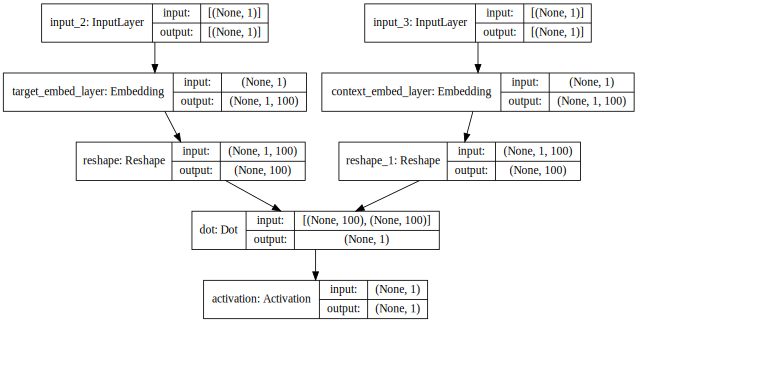

In [29]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  


###**6.Training the Model**

Run the following block of code to train the model for 5 epochs:

In [30]:
import numpy as np

NUM_EPOCHS = 5

for epoch in range(1, NUM_EPOCHS+1):
    epoch_loss = 0
    for i, sent_examples in enumerate(skip_grams[:10000]):
        target_wds = np.array([pair[0] for pair in sent_examples[0]], dtype='int32')
        context_wds = np.array([pair[1] for pair in sent_examples[0]], dtype='int32')
        labels = np.array(sent_examples[1], dtype='int32')
        X = [target_wds, context_wds]
        Y = labels
        if i % 5000 == 0: 
        	print('Processed %d sentences' %i)
        epoch_loss += model.train_on_batch(X, Y)
    print('Processed all %d sentences' %i)
    print('Epoch:', epoch, 'Loss:', epoch_loss, '\n')



Processed 0 sentences
Processed 5000 sentences
Processed all 9999 sentences
Epoch: 1 Loss: 1862.2674378398806 

Processed 0 sentences
Processed 5000 sentences
Processed all 9999 sentences
Epoch: 2 Loss: 1419.2041484704241 

Processed 0 sentences
Processed 5000 sentences
Processed all 9999 sentences
Epoch: 3 Loss: 1356.0557269393466 

Processed 0 sentences
Processed 5000 sentences
Processed all 9999 sentences
Epoch: 4 Loss: 1326.069272265071 

Processed 0 sentences
Processed 5000 sentences
Processed all 9999 sentences
Epoch: 5 Loss: 1302.120917307213 



The training takes about 10 minutes to run.

<br>

In the introduction, we outlined two approaches to training using the skipgram architecture. In this tutorial, we implemented the negative sampling training approach. While waiting for the training to complete, read this article http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/. It contains the skipgram model with softmax training. 

<br>

After reading the article, answer the following questions:  
●	What would the inputs and outputs to the model be?

●	How would you use the Keras framework to create this architecture?

●	What are the reasons this training approach is 
considered inefficient?


### What would be the Inputs and Outputs to the model be?

#### Inputs are wordtoindex of context word and target word. Outputs are probability of pair is positive or negative

### How would you use the Keras framework to create this architecture?
#### Define the layers in the model. Connect the flow of input and outputs through each layer. Fit the model and then evaluate on test data to get fast and accurate results.

### What are the reasons this training approach is considered inefficient?
#### Sometimes when we use two different embedding Matrices , same word may have different vectors.

###**7. Getting the Word Embeddings**

The word embeddings are the weights of the target word embedding layer.


In [31]:
word_embeddings = model.get_layer('target_embed_layer').get_weights()[0] 

# should return (VOCAB_SIZE, EMBED_SIZE)
print(word_embeddings.shape)

(10808, 100)


Print out a few words and their embeddings using the next block of code. Your output may not be exactly as above but the command should print 10 words and their respective vectors.

In [32]:
from pandas import DataFrame

print(DataFrame(word_embeddings, index=idx2word.values()).head(10))

                   0         1         2   ...        97        98        99
Sense        0.010083 -0.012033 -0.016542  ...  0.003729 -0.014503  0.019011
Sensibility  0.010376 -0.023291  0.008540  ...  0.030873 -0.024183  0.011487
Jane         0.016210 -0.014352  0.023118  ...  0.020753 -0.014591  0.034952
Austen       0.011112 -0.078037  0.038333  ...  0.008071  0.010603  0.035187
The          0.005096 -0.014580 -0.007197  ...  0.015193 -0.015456  0.022403
family       0.027164 -0.017446 -0.005271  ... -0.011948  0.054367  0.092967
Dashwood    -0.145946 -0.032238  0.018873  ...  0.052960 -0.162810  0.091453
long        -0.236915 -0.052849  0.114623  ...  0.102109 -0.154706 -0.048957
settled      0.067867 -0.000789 -0.019915  ...  0.061657 -0.019171  0.089344
Sussex       0.053522 -0.021792  0.059648  ...  0.058734 -0.012536  0.010037

[10 rows x 100 columns]


###**8.  Measuring Similarity Between Word Pairs**



In [33]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(word_embeddings)

# should print(VOCAB_SIZE, VOCAB_SIZE)
print(similarity_matrix.shape)   

(10808, 10808)


Matrix is generated to show similarity between the words in the Vocabulary.

###**9. Exploring and Visualizing your Word Embeddings using t-SNE**

**A.	Get the most similar words to the search items in the list below**

search_terms = ['family', 'love', 'equality', 'wisdom', 'justice',  'humour', 'rejection']


**Sanity check:**
The similar words obtained would depend on your training but the above command should print a dictionary. Each key is a search term and each value is a list of the 5 words the model predicts to be most similar to the key word. 


In [38]:
search_terms = ['family', 'love', 'equality', 'wisdom', 'justice', 'humour', 'rejection']

# write code to get the 5 words most similar to the words in search_terms
for index in range(len(search_terms)):
  index = index
  similarwords  = [idx2word[i] for i in list(np.argsort(similarity_matrix[word2idx[search_terms[index]]])[-6:-1])]
  print('5 similar words for {}'.format(search_terms[index]),similarwords)
index = 2
similarwords  = [idx2word[i] for i in list(np.argsort(similarity_matrix[word2idx[search_terms[index]]])[-6:-1])]
print('5 similar words for {}'.format(search_terms[index]),similarwords)

5 similar words for family ['much', 'see', 'replied', 'making', 'Edward']
5 similar words for love ['need', 'afraid', 'fair', 'reason', 'rather']
5 similar words for equality ['Have', 'Now', 'Did', 'Come', 'advise']
5 similar words for wisdom ['en', 'Sandersons', 'vicinity', 'crosses', 'recited']
5 similar words for justice ['Did', 'droll', 'All', 'Indeed', 'affording']
5 similar words for humour ['persuading', 'Yes', 'gladly', 'intimate', 'gives']
5 similar words for rejection ['blushing', 'light', 'congratulate', 'refusal', 'defence']
5 similar words for equality ['Have', 'Now', 'Did', 'Come', 'advise']


In [44]:
search_terms = ['think', 'thought', 'friend', 'love', 'disdain']

# write code to get the 5 words most similar to the words in search_terms
for idx in range(len(search_terms)):
  idx = idx
  similarwords  = [idx2word[i] for i in list(np.argsort(similarity_matrix[word2idx[search_terms[idx]]])[-6:-1])]
  print('5 similar words for {}'.format(search_terms[idx]),similarwords)

idx = 2
similarwords  = [idx2word[i] for i in list(np.argsort(similarity_matrix[word2idx[search_terms[idx]]])[-6:-1])]
print('5 similar words for {}'.format(search_terms[idx]),similarwords)

5 similar words for think ['But', 'You', 'may', 'shall', 'cannot']
5 similar words for thought ['But', 'extremely', 'find', 'You', 'cannot']
5 similar words for friend ['farther', 'Harriet', 'found', 'seeing', 'girl']
5 similar words for love ['need', 'afraid', 'fair', 'reason', 'rather']
5 similar words for disdain ['ONE', 'tolerate', 'Donwell', 'Very', 'awkward']
5 similar words for friend ['farther', 'Harriet', 'found', 'seeing', 'girl']


**B. Plot the words in the dictionary above using t-SN**E https://lvdmaaten.github.io/tsne/ 

Plot 50 of the word embeddings using the code snippets below:














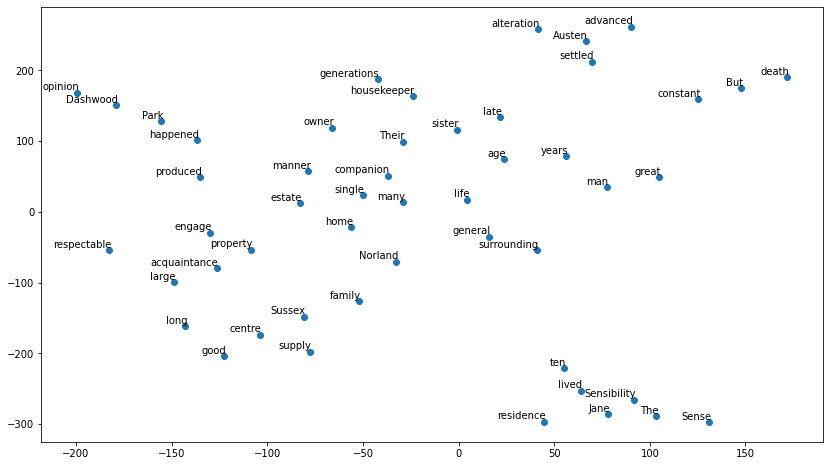

In [45]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=5000, method='exact')
np.set_printoptions(suppress=True)
plot_only = 50 

T = tsne.fit_transform(word_embeddings[:plot_only, :])
labels = [idx2word[i+1] for i in range(plot_only)]
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1])
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points', ha='right', va='bottom')                      	                        



**10. Resources used**

http://jalammar.github.io/illustrated-word2vec/
https://adventuresinmachinelearning.com/word2vec-tutorial-tensorflow/ 
https://towardsdatascience.com/understanding-feature-engineering-part-4-deep-learning-methods-for-text-data-96c44370bbfa 
https://adventuresinmachinelearning.com/word2vec-keras-tutorial/ 
https://www.tensorflow.org/tutorials/representation/word2vec#the_skip-gram_model 
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py 

